Tarea Machine Learning

David Perez Diaz - 47347003P

_Notas:_

_Debido a la configuracion de mi teclado (English Setup) no tengo acceso a la tecla enye, por lo que cada vez que se necesite una enye se vera sustituida por ny._

### Indice

1. Importacion de librerias necesarias, datos y interpretacion.

2. Exploracion de datos (EDA)

3. Preprocesado

4. Transformacion de variables

5. Modelos

6. Prediccion

#### 1. Importacion de librerias necesarias, datos y interpretacion.


In [2]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (12,8)
import seaborn as sns
import sys
import pycountry
import missingno as msno

notebook_directory = os.path.dirname(os.path.abspath('__file__'))
myfunctionspath = os.path.abspath(os.path.join(notebook_directory, '..', '..'))
sys.path.append(myfunctionspath)
from NuestrasFunciones import *

from sklearn.preprocessing import scale, StandardScaler, OrdinalEncoder

from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from time import time

import warnings
warnings.filterwarnings('ignore')

In [55]:
def columsdropper(X, columns):
    X.drop(columns=columns, inplace=True)

def outliers(X, columns):
    X[columns] = X[columns].apply(lambda x: gestiona_outliers(x, clas = 'miss'))

In [3]:
folder_path = os.path.join('.\\competition')
datatraining = os.path.join(folder_path, 'Training_SetValues.csv')
labelstraining = os.path.join(folder_path, 'Training_SetLabels.csv')
datatest = os.path.join(folder_path, 'Test_SetValues.csv')

In [4]:
VarObj = pd.read_csv(labelstraining)

VarObj['status_group'] = VarObj['status_group'].map( {'non functional':0,
                                                     'functional needs repair':1,
                                                    'functional':2} ).astype(int)

In [5]:
data_train = pd.read_csv(datatraining)
data_train_labels = pd.read_csv(labelstraining)
data_test = pd.read_csv(datatest)

Nos encontramos con un dataset con 74250 entradas y 40 columnas, previamente separada como _data-train_, _data-train-labels_ y _data-test_. Este ultimo es el dataset para realizar la prediccion en el sitio web del concurso. 

Para realizar la limpieza de datos, concatenamos _data-train_ y _data-test_, de esa forma evitamos realizar la misma operacion para dos datasets diferentes. Sin embargo, solo observaremos _data-train_, para evitar sesgo.

In [6]:
X = pd.concat([data_train, data_test], axis= 0)

#### 2. Exploracion de datos (EDA)

Una vez ambos datsets concatenados, procedemos a echar un vistazo rapido a los datos, previa depuracion.

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 69746 non-null  object 
 4   gps_height             74250 non-null  int64  
 5   installer              69718 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74250 non-null  object 
 9   num_private            74250 non-null  int64  
 10  basin                  74250 non-null  object 
 11  subvillage             73780 non-null  object 
 12  region                 74250 non-null  object 
 13  region_code            74250 non-null  int64  
 14  district_code          74250 non-null  int64  
 15  lg

In [61]:
X.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [11]:
bin_val = ['public_meeting','permit']
num_val = ['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude','num_private','region_code','district_code','population','construction_year']
cat_val = []
for column in X.columns:
    if column not in num_val+bin_val:
        cat_val.append(column)

In [63]:
data_train.nunique()

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

                         Counts  Percentage
functional                32259   54.308081
non functional            22824   38.424242
functional needs repair    4317    7.267677


<Axes: >

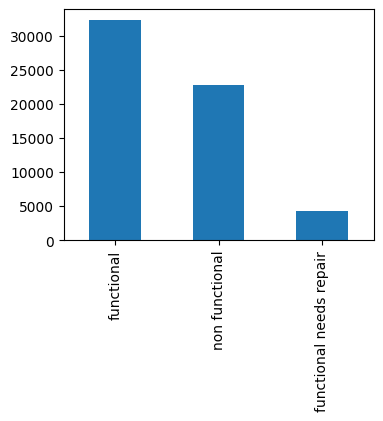

In [9]:
print(pd.DataFrame({'Counts': data_train_labels['status_group'].value_counts(),
                    'Percentage': data_train_labels['status_group'].value_counts()/len(data_train_labels)*100}))
plt.figure(figsize=(4,3))
pd.value_counts(data_train_labels['status_group']).plot.bar()


In [65]:
data_train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [66]:
data_train.describe(exclude=np.number)

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400,55765,55745,59400,59400,59029,59400,59400,59400,56066,59400,55523,31234,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,356,1897,2145,37400,9,19287,21,125,2092,2,1,12,2696,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,572,9084,17402,3563,10248,508,5294,2503,307,51011,59400,36793,682,38852,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625


Rapidamente, observamos varias anomalias en algunas variables. En primer lugar, en cuento a las variables numericas, percibimos cierta concentracion de valores (especialmente 0), asi como valores perdidos. Por otro lado, en cuanto a las categoricas, observamos variables con nombres muy parecidos, algunos con una alta cardinalidad, ademas de algunos con un unico valor.

Procedemos a realizar representaciones graficas tanto para las variables numericas como las categoricas.

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'amount_tsh'}>,
        <Axes: title={'center': 'gps_height'}>],
       [<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'num_private'}>],
       [<Axes: title={'center': 'region_code'}>,
        <Axes: title={'center': 'district_code'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'construction_year'}>, <Axes: >,
        <Axes: >]], dtype=object)

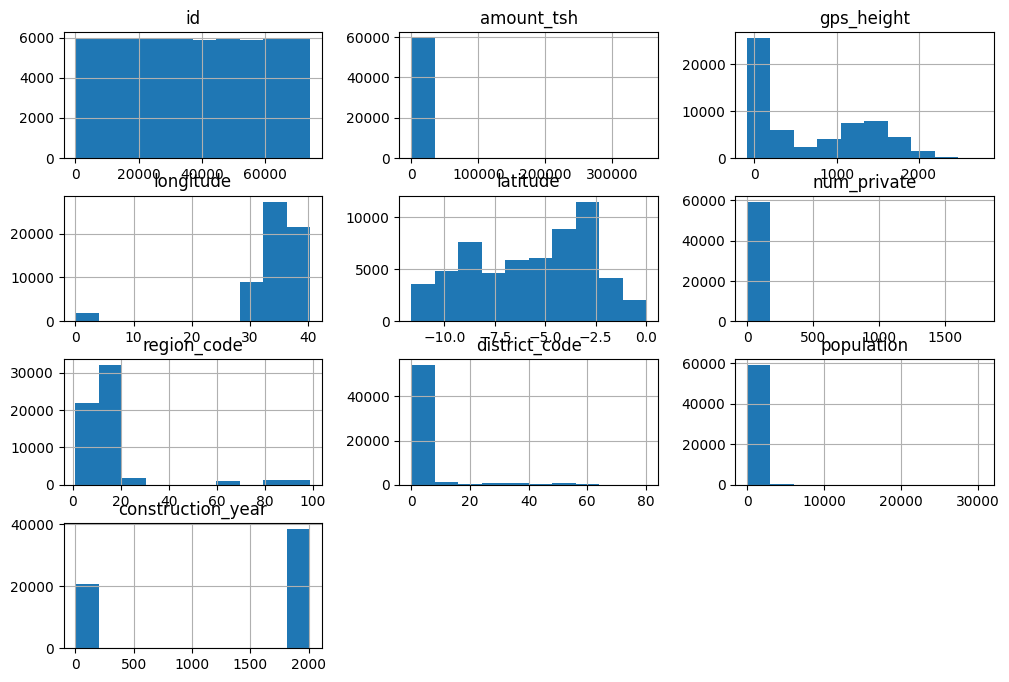

In [16]:
data_train[num_val].hist()

In [32]:
data_train_labels['status_group'].value_counts().index

Index(['functional', 'non functional', 'functional needs repair'], dtype='object')

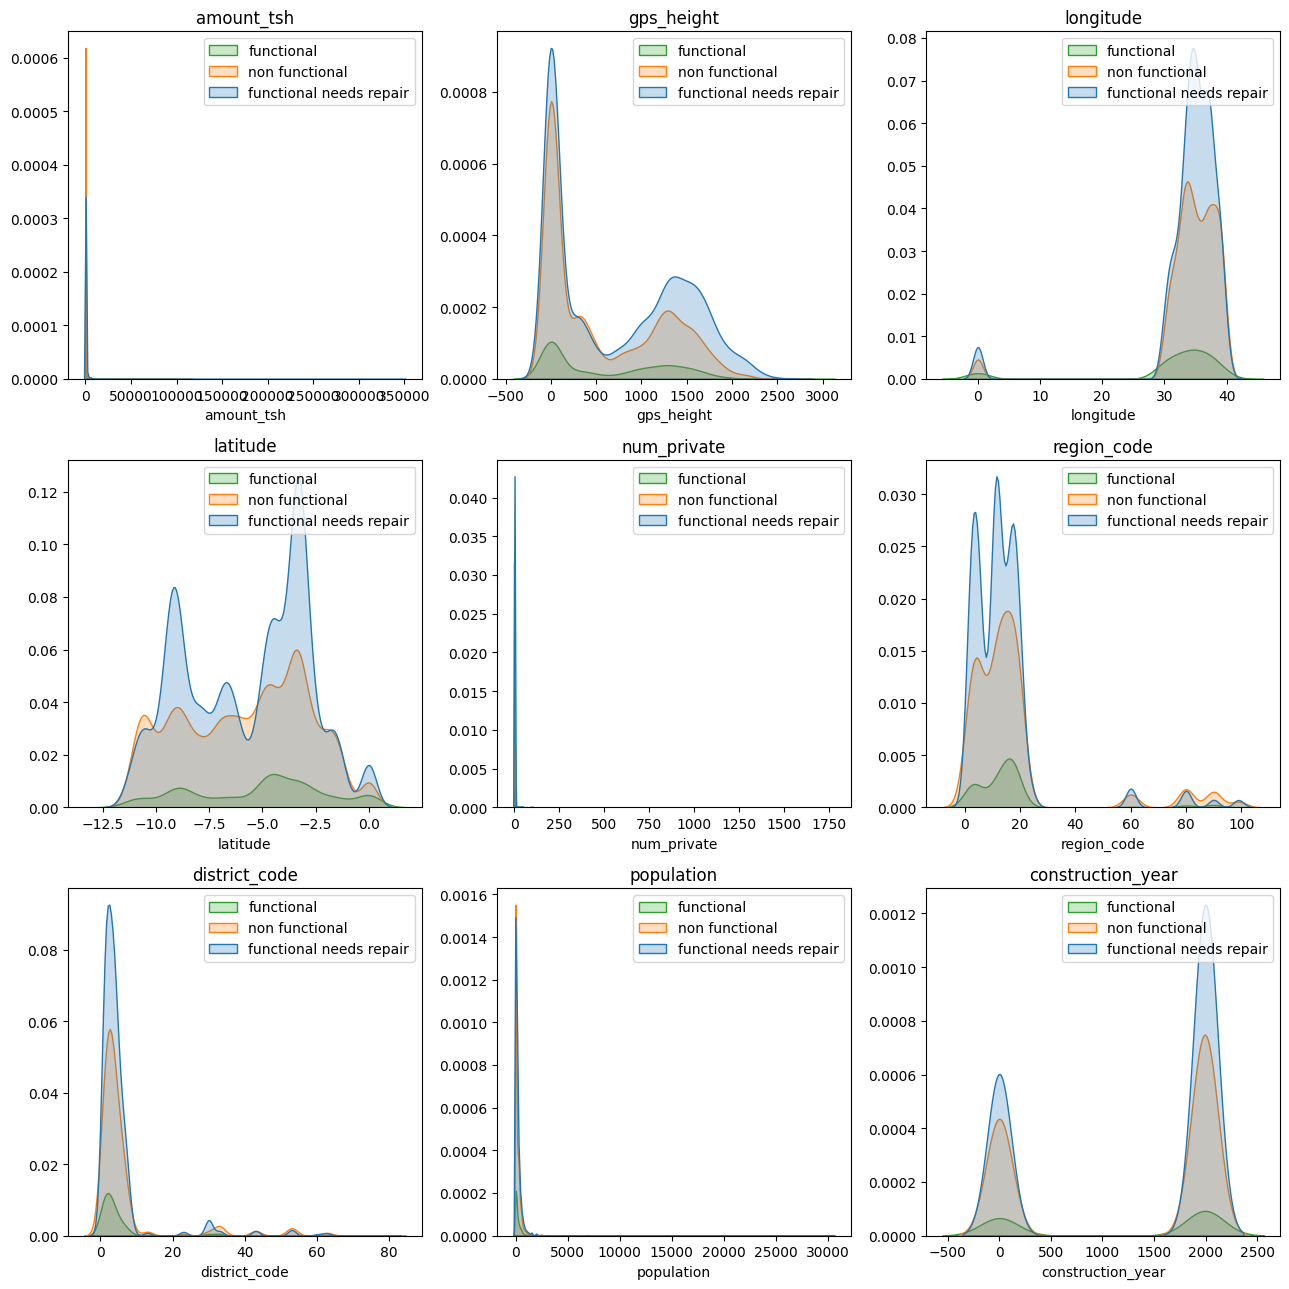

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 16))
axes = axes.ravel()
numerical_columns = data_train[num_val].drop(columns='id').columns
for i, column in enumerate(numerical_columns):
    sns.kdeplot(data=data_train, x=column, hue=data_train_labels['status_group'], fill=True, common_norm=True, ax=axes[i])
    axes[i].set_title(column)
    axes[i].legend(data_train_labels['status_group'].value_counts().index)
    axes[i].set_ylabel('')
plt.tight_layout()

In [40]:
mask = data_train.nunique() < 20
data_cat = data_train.loc[:,mask]

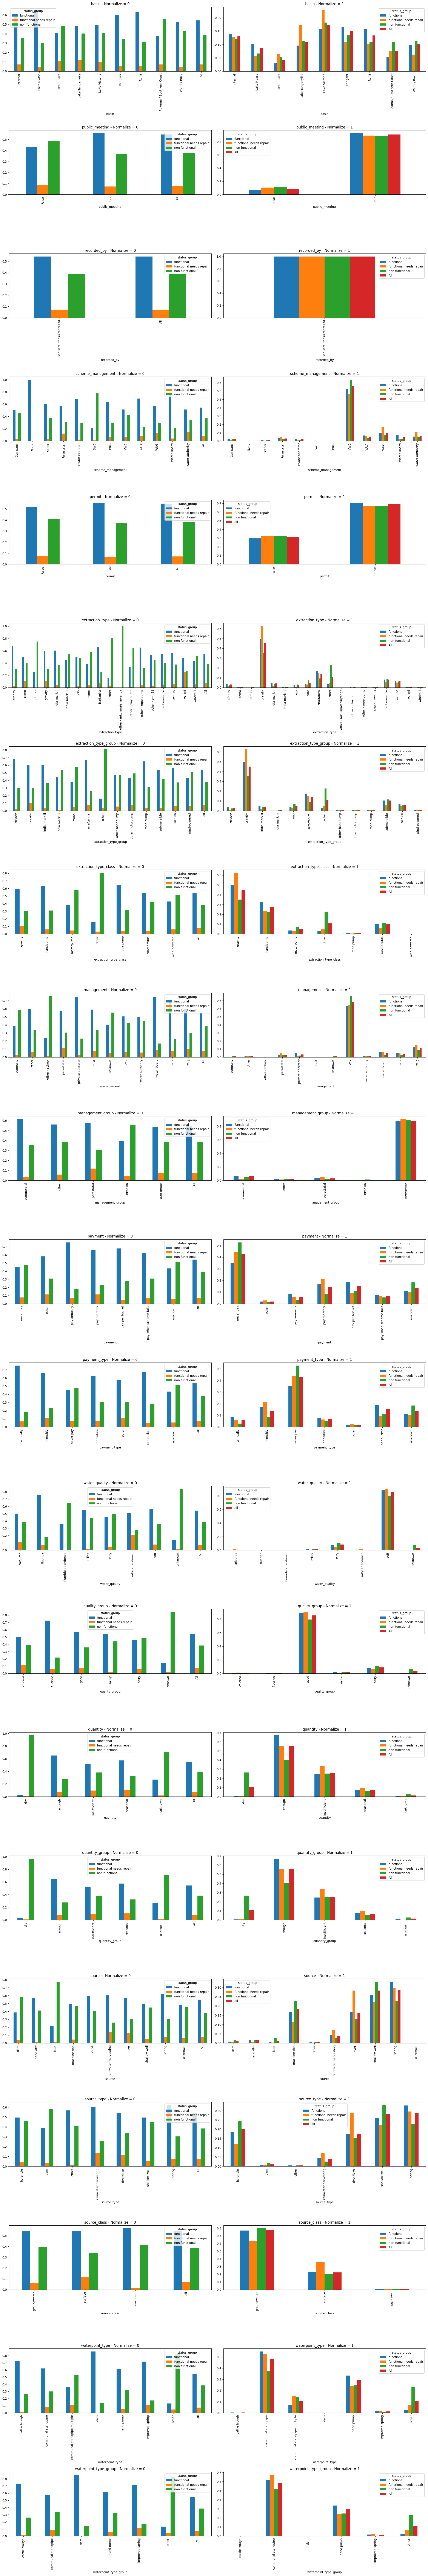

In [79]:
fig, axes = plt.subplots(nrows=21, ncols=2, figsize=(20, 120))
for index, column in enumerate(data_cat.columns):
    crosstab_n1 = pd.crosstab(data_cat[column], data_train_labels['status_group'], margins=True, normalize=1).round(3)
    crosstab_n0 = pd.crosstab(data_cat[column], data_train_labels['status_group'], margins=True, normalize=0).round(3)
    crosstab_n0.plot(kind='bar', ax=axes[index, 0])
    axes[index, 0].set_title(f"{column} - Normalize = 0")
    crosstab_n1.plot(kind='bar', ax=axes[index, 1])
    axes[index, 1].set_title(f"{column} - Normalize = 1")
plt.tight_layout()
plt.show()

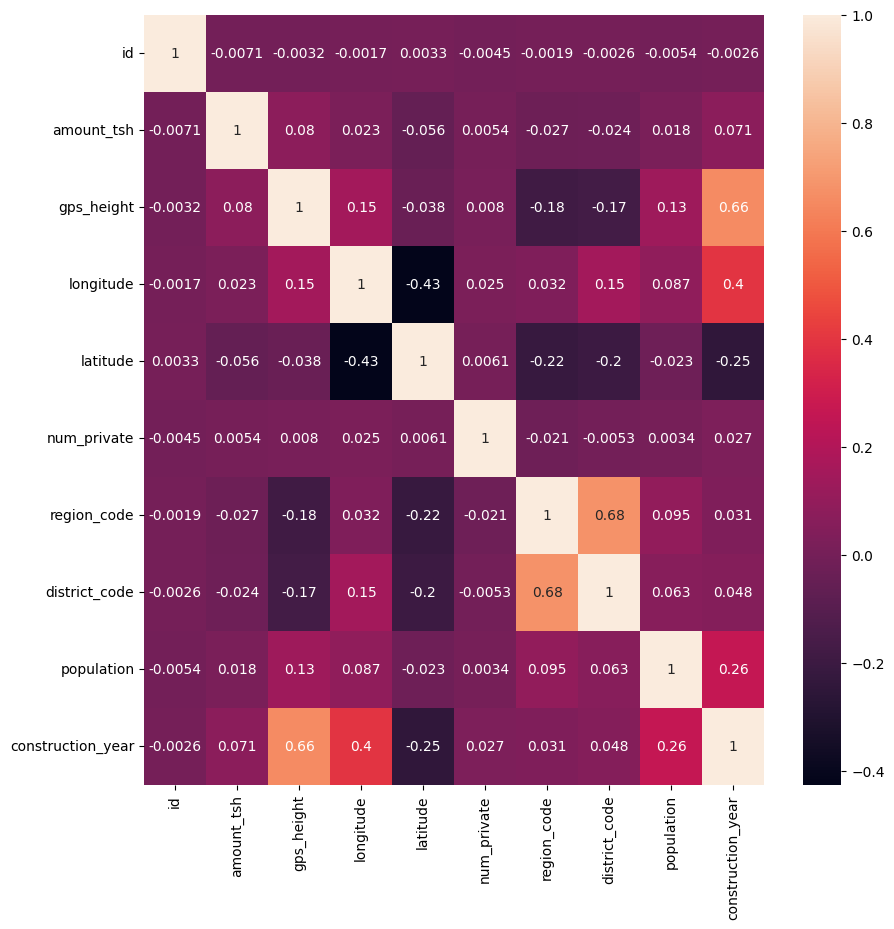

In [78]:
plt.figure(figsize=(10,10))
cor = X.corr()
sns.heatmap(cor, annot=True)
plt.show()

In [72]:
def detect_same_variable(data, columns):
    print(data.groupby(columns).size())
    
list1 = ['extraction_type', 'extraction_type_group', 'extraction_type_class']
list2 = ['management', 'management_group', 'scheme_management']
list3 = ['water_quality','quality_group']
list4 = ['waterpoint_type', 'waterpoint_type_group']
list5 = ['district_code', 'region_code', 'region']
list6 = ['source_class','source', 'source_type']
list7 = ['quantity', 'quantity_group']
list8 = ['payment', 'payment_type']


for i in list1, list2, list3, list4, list5, list6, list7:
    detect_same_variable(data_train, i)

extraction_type            extraction_type_group  extraction_type_class
afridev                    afridev                handpump                  1770
cemo                       other motorpump        motorpump                   90
climax                     other motorpump        motorpump                   32
gravity                    gravity                gravity                  26780
india mark ii              india mark ii          handpump                  2400
india mark iii             india mark iii         handpump                    98
ksb                        submersible            submersible               1415
mono                       mono                   motorpump                 2865
nira/tanira                nira/tanira            handpump                  8154
other                      other                  other                     6430
other - mkulima/shinyanga  other handpump         handpump                     2
other - play pump          other hand

Tras realizar el analisis grafico, podemos confirmar lo planteado anteriormente. Exiten algunas variables numericas que presentan una alta concentracion de valores, especialmente en 0. Estas variables son potencialmente candidatas a ser eliminadas del dataset, ya que su aportacion es bastante discutible.\

Por otro lado, como tambien anticipamos, tenemos variables categoricas muy similares entre si por lo que, para poder evitar un problema de colinealidad de cara a modelo, estas deberian ser eliminadas. Procedemos a eliminarla en la siguiente linea.\
Asimismo, tenemos la variable _recorded-by_ la cual tiene un valor unico, y por lo tanto, cuya aportacion es nula. Se eliminara junto con las anteriores en la siguiente linea.\

Otra caracteristica a senyalar es la precencia de variables categoricas con una alta cardinalidad. Vamos a procedes a observar y analizar esas variables mas adelante.

In [73]:
columns_to_drop = ['id','extraction_type', 'extraction_type_group', 'management','scheme_management', 'water_quality', 'waterpoint_type_group', 'recorded_by','payment','region_code','region','source_class', 'source', 'quantity' ]
columsdropper(X, columns=columns_to_drop)

In [74]:
X.describe(exclude=np.number)

,date_recorded,funder,installer,wpt_name,basin,subvillage,lga,ward,public_meeting,scheme_name,permit,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_type,waterpoint_type
count,74250,69746,69718,74250,74250,73780,74250,74250,70095,38992,70457,74250,74250,74250,74250,74250,74250,74250
unique,369,2140,2410,45684,9,21425,125,2098,2,2868,2,7,5,7,6,5,7,7
top,2011-03-17,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Njombe,Igosi,True,K,True,gravity,user-group,never pay,good,enough,spring,communal standpipe
freq,695,11299,21751,4440,12871,646,3128,386,63749,858,48606,33263,65538,31712,63505,41522,21216,35628


Despues de analizar profundamente las variables con un alto numero de caracteristicas, tomamamos las siguientes conclusiones:
- **_installer_**: Caracteristica que parece abordar el origen del instalador. Este repleta de errores que parecen ser que buscan senyalar a un mismo instalador. Procedemos a recoger esos valores que intuitivamente se pueden agregar y recogerlos en un diccionario.
- **_funder_** = Variable con caracteristicas muy similares a la anterior aunque con diferente proposito. Realizamos la misma transforamacion.
- **_ward_** = Cualidad relacionada con la la localizacion del _waterpoint_, concretamente nombre la ciudad. La consideramos redundate por que ya tenemos la categoria _region-code_, la cual establece una mejor categorizacion para la localizacion.
- **_subvillage_** = Variable muy relacionada con la anterior. Obtenemos la misma conclusion.
- **_lga_** = Variable muy relacionada con la anterior. Obtenemos la misma conclusion.
- **_wpt-name_** = Caracteristica poco predecible y confusa, ademas de un amplio rango de valores. Parece estar relacionada con el nombre del _waterpoint_ Candidata a ser eliminada.
- **_scheme-name_** = Caracteristica poco predecible y confusa, ademas de un amplio rango de valores, ademas de demasiados valores nulos. Candidata a ser eliminada.


Procedemos a eliminar aquellas que consideramos que aportan poco valor predictivo, asi como corregir aquellas que creemos que pueden aportar valor.
Para la correcion de las otras, definiremos la funcion _replace-strings_.

In [75]:
colums_to_drop1 = ['scheme_name', 'amount_tsh','subvillage','ward','wpt_name','lga','scheme_name']
columsdropper(X,colums_to_drop1)

In [76]:
def replace_strings(X, column, replacements, search_type='exact'):
    X = X.copy()
    for search_string, replacement in replacements.items():
        if search_type == 'exact':
            mask = X[column].str.lower() == search_string.lower()
        elif search_type == 'partial':
            mask = X[column].str.lower().str.contains(search_string.lower())
        else:
            raise ValueError(f"Invalid search_type: {search_type}")
        X.loc[mask, column] = replacement
    return X

In [77]:
replacements_installer = {
    'dwe': 'DWE',
    'comm': 'Community',
    'dani': 'DANIDA',
    'cou': 'Council',
    'distr': 'Council',
    'hesa': 'HESAWA',
    'gov': 'Goverment',
    'depa': 'Water Departments',
    'unice' : 'UNICEF',
    'cefa' : 'CEFA',
    'ox': 'OXFAM',
    'unisef' : 'UNICEF',
    'unicrf':'UNICEF',
    'kkk': 'KKKT',
    'chur' : 'Church',
    'visi' : 'World Vision',
    'vission' : 'World Vision',
    'bank' : 'World Bank',
    'afri' :'ONG',
    'dw': 'DWE',
    'wat': 'Water Management',
    'tech' : 'Technicians',
    'tanz' : 'Tanzania',
    'cons' : 'Consulting',
    'tasa' : 'TASAF',
    'nora': 'NORAD',
    'dm':'DMDD'
}

X['installer'].fillna('0', inplace=True)
X = replace_strings(X, 'installer', replacements_installer, search_type='partial')
X['installer'] = X['installer'].replace(['Consulting', 'Technicians'], 'Private')
X['installer'] = X['installer'].replace('0', np.nan)

In [78]:
installer_value_counts = X['installer'].value_counts()
values_to_replace = installer_value_counts.index[3:]
X.loc[X['installer'].isin(values_to_replace), 'installer'] = 'Other'

In [79]:
replacements_funder = {
    'DWE': 'DWE',
    'comm': 'Community',
    'dani': 'DANIDA',
    'cou': 'Council',
    'distr': 'Council',
    'hesa': 'HESAWA',
    'gov': 'Goverment',
    'depa': 'Water Departments',
    'minis': 'Ministries',
    'unice' : 'UNICEF',
    'cefa' : 'CEFA',
    'ox': 'OXFAM',
    'Unisef' : 'UNICEF',
    'UNICRF':'UNICEF',
    'kkk': 'KKKT',
    'chur' : 'Church',
    'visi' : 'World Vision',
    'vission' : 'World Vision',
    'bank' : 'World Bank',
    'afri' :'ONG',
    'dw': 'DWE',
    'wat': 'Water Management',
    'tech' : 'Technicians',
    'tanz' : 'Goverment',
    'cons' : 'Consulting',
    'tasa' : 'TASAF',
    'nora': 'NORAD',
    'dm':'DMDD',
    'priv': 'Private',
    'amre' : 'AMREF',
    'plan': 'Plan International',
}
countries = [country.name for country in pycountry.countries]
X['funder'].fillna('0', inplace=True)

X = replace_strings(X, 'funder', replacements_funder, search_type='partial')
X['funder'] = X['funder'].replace(countries, 'Country Friend')
X['funder'] = X['funder'].replace(['Germany Republi', 'China Government','European Union'],'Country Friend')
X['funder'] = X['funder'].replace(['Consulting', 'Technicians'], 'Private')
X['funder'] = X['funder'].replace('0', np.nan)

In [80]:
installer_value_counts = X['funder'].value_counts()
values_to_replace = installer_value_counts.index[5:]
X.loc[X['funder'].isin(values_to_replace), 'funder'] = 'Other'

En cuanto a las variables numericas, observamos demasiados 0, y pocos valores NaN. Esto hace indicar que en la originacion del dataset, se ha tratado al 0 como valor nulo. Realizaremos la conversion a NaN.

In [81]:
columns_to_nan = ['permit','public_meeting', 'construction_year','population','gps_height','longitude']

for column in columns_to_nan:
    X[column].replace(0,np.nan,inplace=True)

In [82]:
bin_to_int =  ['permit', 'public_meeting']
for column in bin_to_int:
    X[column]  = X[column].replace({True:1, False:0})

#### 3. Preprocesado
##### 3.1 Observacion Valores missing

In [84]:
num_columns = X.select_dtypes(include=np.number).columns.to_list()
num_columns.remove('district_code')

,variable,Unique values,Nan %,zeros %
9,population,1128,36.1,0.0
12,construction_year,55,35.0,0.0
2,gps_height,2456,34.5,0.0
11,permit,2,34.5,0.0
10,public_meeting,2,14.1,0.0
3,installer,5,7.4,0.0
1,funder,7,7.4,0.0
4,longitude,71870,3.1,0.0
14,management_group,5,0.0,0.0
18,source_type,7,0.0,0.0


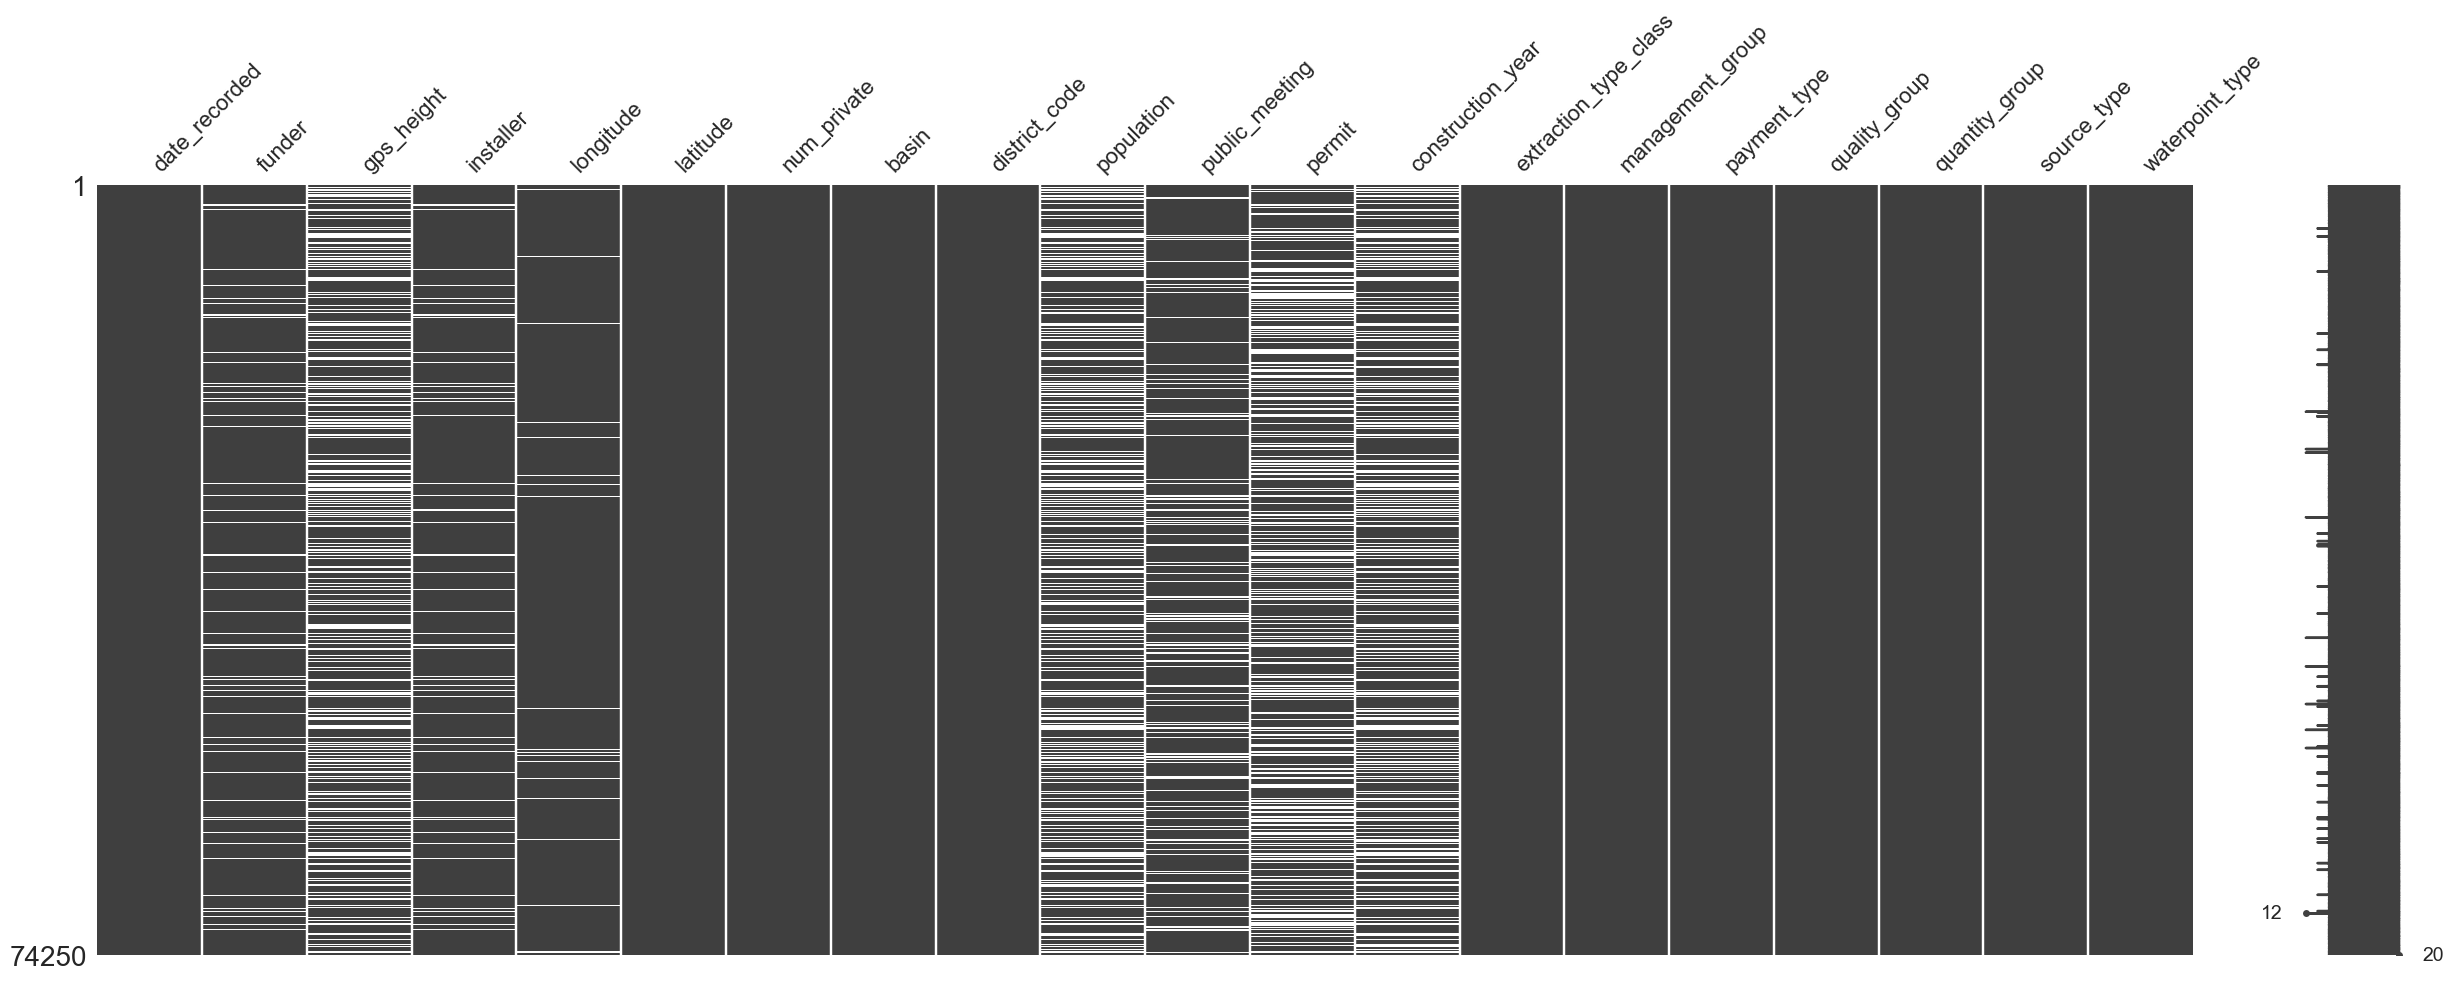

In [85]:
missing_values(X)

<Axes: >

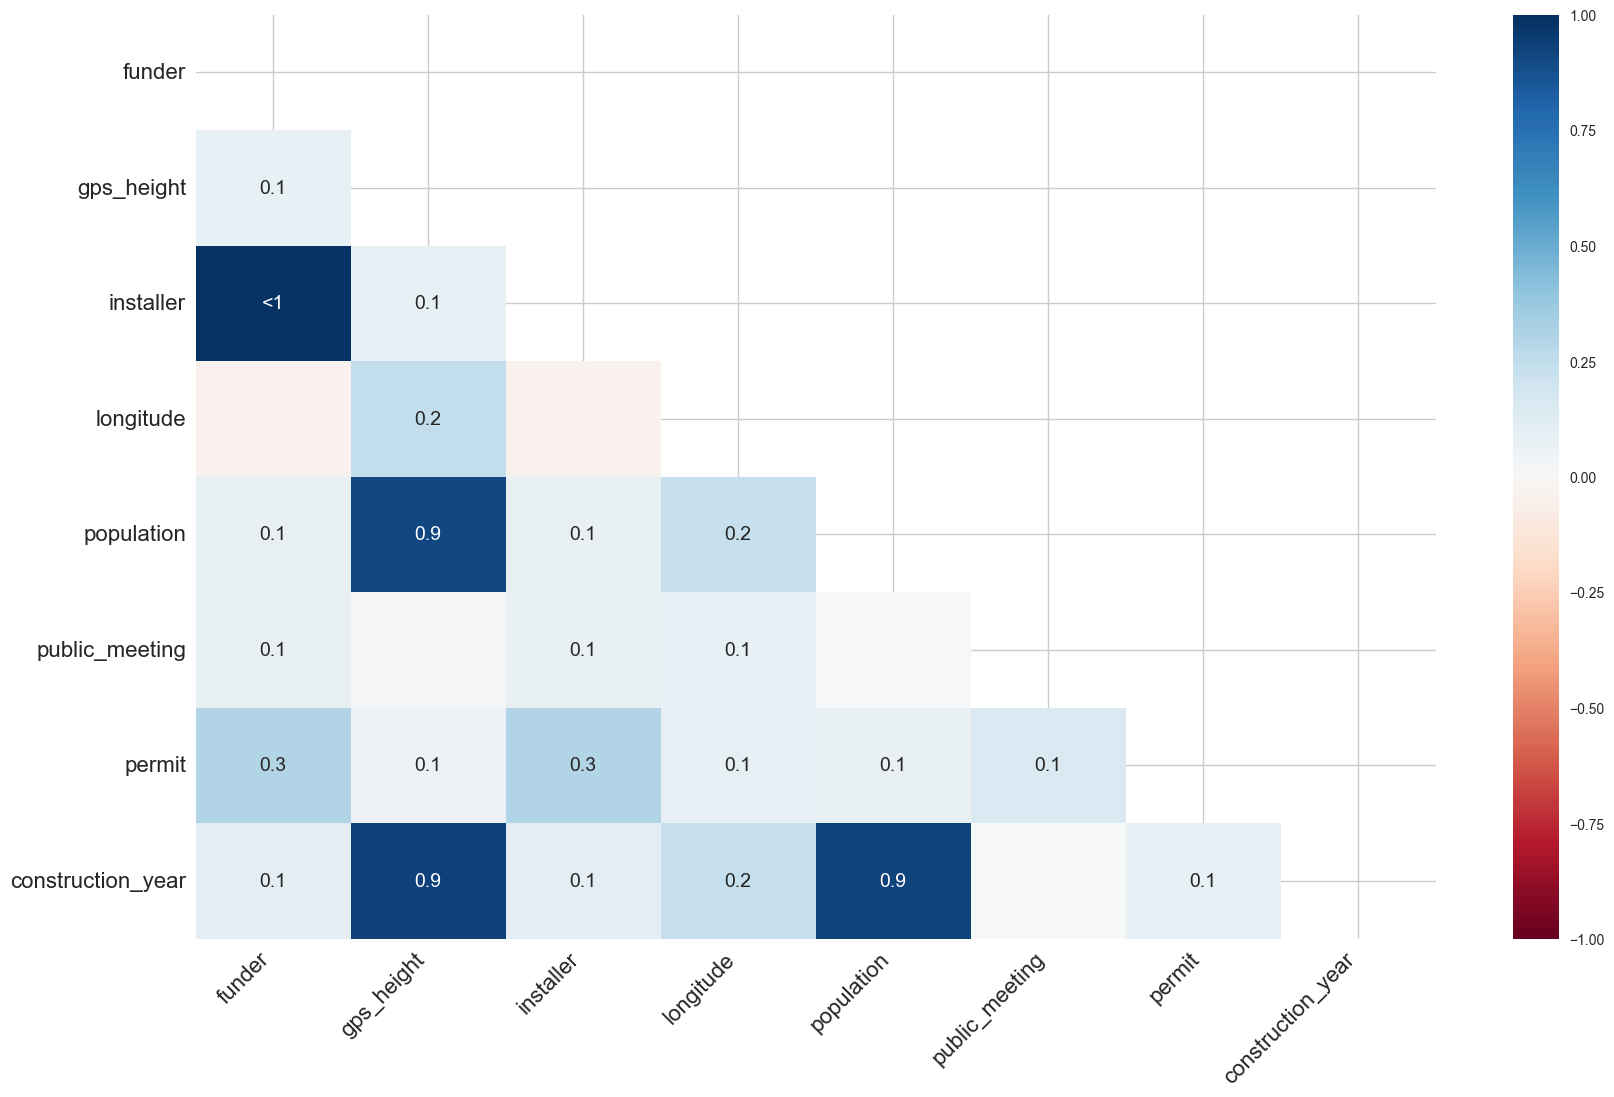

In [86]:
msno.heatmap(X)

Despues de observar los valores _missings_, se eliminara la variable _num-private_, por su alta concentracion de 0.

In [89]:
X.drop(columns='num_private', inplace=True)
num_columns.remove('num_private')

##### 3.2 Outliers

##### Gestionamos los _outliers_ convirtiendolos a NaN, con una funcion importada.

In [90]:
outliers(X, num_columns)

gps_height

 MissingAntes: 25649
MissingDespues: 25649

longitude

 MissingAntes: 2269
MissingDespues: 2269

latitude

 MissingAntes: 0
MissingDespues: 0

population

 MissingAntes: 26834
MissingDespues: 27409

public_meeting

 MissingAntes: 10501
MissingDespues: 10501

permit

 MissingAntes: 25644
MissingDespues: 25644

construction_year

 MissingAntes: 25969
MissingDespues: 25969



##### 3.3 Creacion nuevas caracteristicas

Procedemos a la creacion de nuevas caracteristicas en base a algunas existentes. Las nuevas variables van a ser:
- _recorded-year_ = Registrara el anyo de creacion del _waterpoint_
- _recorded-moth_ = Registrara el mes de creacion del _waterpoint_
- _binary-payment_ = Variable binaria donde 1 es pago y 0 ausencia del mismo.

In [91]:
X['date_recorded'] = pd.to_datetime(X['date_recorded'])
X['recorded_year'] = X['date_recorded'].dt.year
X['recorded_month'] = X['date_recorded'].dt.month

In [92]:
X['payment_binary'] = X['payment_type'].apply(lambda x: 0 if x == 'never pay' else 1)

##### 3.4 Imputacion de valores perdidos

Una vez relizado la transformacion de las variables realizaremos la imputacion de variables perdidos donde utilizaremos lo siguiente:
- _KNNImputer_ = Funcion de _sklearn_ que imputa valores numericos basado en la tecnica de _k-Nearest-Neighbors_. Aunque esta imputacion tiende a sobreajustar (_overfitting_), ha sido escogido por encima de otra (moda o mediana). Debido a la alta concentracion de NaN en algunas numericas, la imputacion por valores unicos podria conducir a concentracion de los mismos.

- _SimpleImputer-mode_ = Para las variables caterigoricas elegimos imputar mediante moda.

In [ ]:
imputer_knn = KNNImputer(n_neighbors=3, missing_values=np.nan)
imputer_moda = SimpleImputer(strategy='most_frequent', missing_values=np.nan)

#### 4. Transformacion de variables.

Para la transformacion de variables, utilizaremos la funcion _Pipeline_ de _sklearn_ para poder hacer la conversion tanto para variablers categoricas como numericas. Utilizaremos los siguientes metodos:

- _Ordinal-Encoder_ =  Funcion proveniente _sklearn_ para transformar variables categoricas. Asigna un valor numerico a cada caracteristica.

- _StandardScaler_ = Misma provenencia para escalar variables numericas.

In [ ]:
cat_attribs = X.select_dtypes(exclude=np.number).columns.tolist()
num_attribs = X.select_dtypes(include=np.number).columns.tolist()

num_attribs.remove('district_code')
num_attribs.remove('recorded_month')
cat_attribs.append('district_code')
cat_attribs.append('recorded_month')

In [ ]:
from sklearn import set_config
set_config(transform_output="pandas")

cat_pipeline = Pipeline([
    ('imputer', imputer_moda),
    ('std', OrdinalEncoder())
])

num_pipeline = Pipeline([
    ('imputer', imputer_knn),
    ('std', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ("cat", cat_pipeline, cat_attribs),
    ("num", num_pipeline, num_attribs)
])

X_prepared = full_pipeline.fit_transform(X)

In [ ]:
data_train = X_prepared[:len(data_train)]
data_test = X_prepared[len(data_train):]

In [ ]:
data_test.head()

,cat__funder,cat__installer,cat__basin,cat__public_meeting,cat__permit,cat__extraction_type_class,cat__management_group,cat__payment_type,cat__quality_group,cat__quantity_group,cat__source_type,cat__waterpoint_type,cat__recorded_year,cat__payment_binary,cat__district_code,cat__recorded_month,num__gps_height,num__longitude,num__latitude,num__population,num__construction_year
0,4.0,2.0,0.0,0.0,0.0,3.0,2.0,2.0,2.0,3.0,3.0,6.0,2.0,0.0,3.0,1.0,1.471886,0.094471,0.557590,0.212766,1.365107
1,1.0,0.0,5.0,0.0,0.0,0.0,4.0,2.0,2.0,2.0,6.0,1.0,2.0,0.0,2.0,1.0,0.744615,0.612210,0.812427,0.136114,0.319143
2,4.0,2.0,0.0,0.0,0.0,3.0,4.0,2.0,2.0,2.0,3.0,6.0,2.0,0.0,2.0,1.0,0.741209,-0.103744,0.236821,0.866130,1.190780
3,5.0,3.0,7.0,0.0,0.0,3.0,4.0,6.0,2.0,0.0,5.0,6.0,2.0,1.0,13.0,0.0,-1.472963,1.143378,-1.262127,-0.046390,-0.813985
4,4.0,2.0,7.0,0.0,0.0,0.0,4.0,1.0,2.0,1.0,6.0,1.0,2.0,1.0,3.0,2.0,0.218324,-0.013433,-1.782252,-0.739905,0.319143


In [ ]:
data_train['status_group'] = VarObj['status_group']

In [ ]:
data_train.to_csv('data_train_prepared.csv')
data_test.to_csv('data_test_prepared.csv')

#### 5. Modelizacion

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import  train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier 

Para la realizar la prediccion utilizaremos varios modelos de clasificacion. Empezaremos realizando una particion _train_ y _test_. Me hubiera gustado utilizar todo el _dataset_ de _train_ para realizar el entrenamiento pero debido a la limitada cantidad de envios en la pagina web del concurso, he decidido dividir el _data-train_.

In [ ]:
df = pd.read_csv('data_train_prepared.csv', index_col=0)
test = pd.read_csv('data_test_prepared.csv', index_col=0)
id = pd.read_csv('SubmissionFormat.csv', index_col=0)
id = id.index

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cat__funder                 59400 non-null  float64
 1   cat__installer              59400 non-null  float64
 2   cat__basin                  59400 non-null  float64
 3   cat__public_meeting         59400 non-null  float64
 4   cat__permit                 59400 non-null  float64
 5   cat__extraction_type_class  59400 non-null  float64
 6   cat__management_group       59400 non-null  float64
 7   cat__payment_type           59400 non-null  float64
 8   cat__quality_group          59400 non-null  float64
 9   cat__quantity_group         59400 non-null  float64
 10  cat__source_type            59400 non-null  float64
 11  cat__waterpoint_type        59400 non-null  float64
 12  cat__recorded_year          59400 non-null  float64
 13  cat__payment_binary         594

In [3]:
X = df.drop(columns='status_group')
y = df['status_group']

In [4]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['status_group'], random_state=42)

In [7]:
rf = RandomForestClassifier(random_state=42)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
svc = SVC(random_state=42)
et = ExtraTreesClassifier()
svc_classifier = SVC(probability=True)
lgbm_classifier = LGBMClassifier(random_state=42)

In [8]:
X_train = df_train.drop(columns='status_group')
y_train = df_train['status_group']
X_test = df_test.drop(columns='status_group')
y_test = df_test['status_group']

### 5.1 KNN

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Cross-validated Accuracy: 
0.7600673400673401
Accuracy:
TRAIN: 0.8303451178451179
TEST: 0.7574915824915824


<Axes: title={'center': 'Confusion Matrix'}>

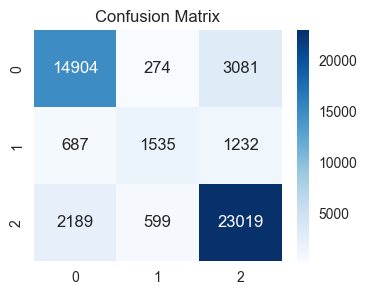

In [14]:
print(knn.__class__)
knn.fit(X_train, y_train) 
y_knn_train = knn.predict(X_train) 
y_knn_test = knn.predict(X_test)
y_knn_cv = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
print('Cross-validated Accuracy: '); print("="*len("Cross-validated Accuracy:")); print(y_knn_cv.mean())
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_knn_train)}")
print(f"TEST: {accuracy_score(y_test, y_knn_test)}")
cm = confusion_matrix(y_train, y_knn_train)
plt.figure(figsize=(4, 3))
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')

### 5.2 DecisionTreeClassifier

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
Cross-validated Accuracy: 
0.7485690235690237

      
Accuracy:
TRAIN: 0.9958333333333333
TEST: 0.7513468013468013


<Axes: title={'center': 'Confusion Matrix'}>

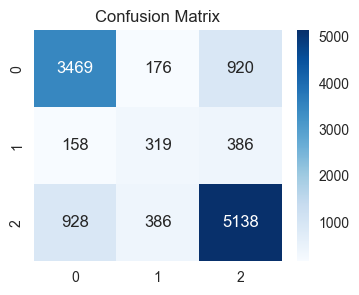

In [15]:
print(dt.__class__)
dt.fit(X_train, y_train) 
y_dt_train = dt.predict(X_train)
y_dt_test = dt.predict(X_test)
y_dt_cv = cross_val_score(dt, X, y, cv=5, scoring='accuracy')
print('Cross-validated Accuracy: '); print("="*len("Cross-validated Accuracy:")); print(y_dt_cv.mean())
print('''
      ''')
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_dt_train)}")
print(f"TEST: {accuracy_score(y_test, y_dt_test)}")
cm = confusion_matrix(y_test, y_dt_test)
plt.figure(figsize=(4, 3))
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')

### 5.3 Random Forest Classifier

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Cross-validated Accuracy: 
0.8031649831649832
Accuracy:
TRAIN: 0.9957912457912458
TEST: 0.8073232323232323


<Axes: title={'center': 'Confusion Matrix'}>

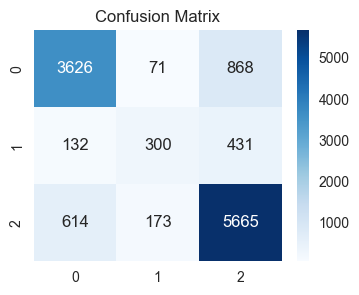

In [16]:
print(rf.__class__)
rf.fit(X_train, y_train) 
y_rf_train = rf.predict(X_train)
y_rf_test = rf.predict(X_test)
y_rf_cv = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print('Cross-validated Accuracy: '); print("="*len("Cross-validated Accuracy:")); print(y_rf_cv.mean())
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_rf_train)}")
print(f"TEST: {accuracy_score(y_test, y_rf_test)}")
cm = confusion_matrix(y_test, y_rf_test)
plt.figure(figsize=(4, 3)) 
plt.title('Confusion Matrix')

sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')

### 5.4.GradientBoostingClassifier

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Cross-validated Accuracy: 
0.7516666666666666
Accuracy:
TRAIN: 0.7545244107744108
TEST: 0.7515151515151515


<Axes: title={'center': 'Confusion Matrix'}>

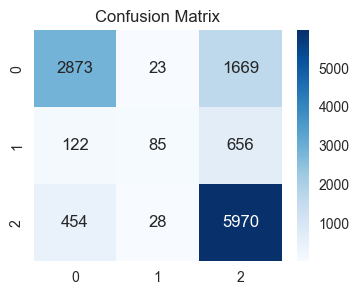

In [17]:
print(gb.__class__)
gb.fit(X_train, y_train) 
y_gb_train = gb.predict(X_train)
y_gb_test = gb.predict(X_test)
y_gb_cv = cross_val_score(gb, X, y, cv=5, scoring='accuracy')
print('Cross-validated Accuracy: '); print("="*len("Cross-validated Accuracy:")); print(y_gb_cv.mean())
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_gb_train)}")
print(f"TEST: {accuracy_score(y_test, y_gb_test)}")
cm = confusion_matrix(y_test, y_gb_test)
plt.figure(figsize=(4, 3))
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')

### 5.5 Extra Tree Classifier

<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>
Cross-validated Accuracy: 
0.7922558922558922
Accuracy:
TRAIN: 0.9958333333333333
TEST: 0.8014309764309764


<Axes: title={'center': 'Confusion Matrix'}>

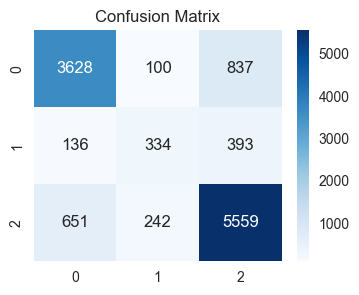

In [18]:
print(et.__class__)
et.fit(X_train, y_train)
y_et_train = et.predict(X_train)
y_et_test = et.predict(X_test)
y_et_cv = cross_val_score(et, X, y, cv=5, scoring='accuracy')
print('Cross-validated Accuracy: ')
print("=" * len("Cross-validated Accuracy:"))
print(y_et_cv.mean())
print("Accuracy:")
print("=" * len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_et_train)}")
print(f"TEST: {accuracy_score(y_test, y_et_test)}")
cm = confusion_matrix(y_test, y_et_test)
plt.figure(figsize=(4, 3))
plt.title('Confusion Matrix') 
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

### 5.6 Sopporter Vector Classifier

<class 'sklearn.svm._classes.SVC'>
Cross-validated Accuracy:
0.7327441077441076
Accuracy:
TRAIN: 0.7371843434343435
TEST: 0.7306397306397306


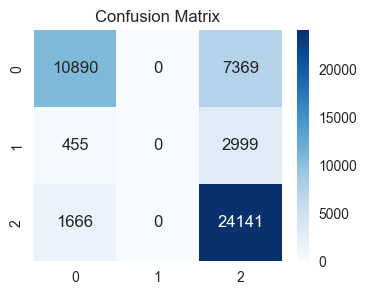

In [10]:
print(svc.__class__)
svc.fit(X_train, y_train)
y_svc_train = svc.predict(X_train)
y_svc_test = svc.predict(X_test)
y_svc_cv = cross_val_score(svc, X, y, cv=5, scoring='accuracy')
print('Cross-validated Accuracy:')
print("=" * len("Cross-validated Accuracy:"))
print(y_svc_cv.mean())
print("Accuracy:")
print("=" * len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_svc_train)}")
print(f"TEST: {accuracy_score(y_test, y_svc_test)}")
cm = confusion_matrix(y_train, y_svc_train)
plt.figure(figsize=(4, 3))
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.show()

### 5.7 Light Gradient Boosting Classifier

<class 'lightgbm.sklearn.LGBMClassifier'>


  File "c:\Users\David Pérez\.virtualenvs\davidpd997-4i8SmjW1\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1241
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 19
[LightGBM] [Info] Start training from score -0.956493
[LightGBM] [Info] Start training from score -2.621618
[LightGBM] [Info] Start training from score -0.610505
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1239
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 19
[LightGBM] [Info] Start training from score -0.956493
[LightGBM] [Info] Start training from score -2.621618
[LightGBM] [Info] 

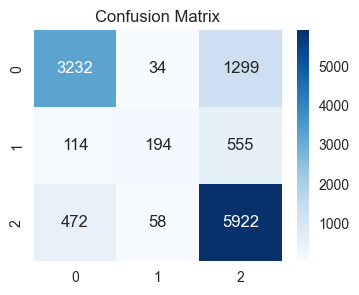

In [11]:
print(lgbm_classifier.__class__)
lgbm_classifier.fit(X_train, y_train)
y_lgbm_cv = cross_val_score(lgbm_classifier, X, y, cv=5, scoring='accuracy')
y_lgbm_train = lgbm_classifier.predict(X_train)
y_lgbm_test = lgbm_classifier.predict(X_test)
print('Cross-validated Accuracy:')
print("=" * len("Cross-validated Accuracy:"))
print(y_lgbm_cv.mean())
print("Train Accuracy:", accuracy_score(y_train, y_lgbm_train))
print("Test Accuracy:", accuracy_score(y_test, y_lgbm_test))
cm = confusion_matrix(y_test, y_lgbm_test)
plt.figure(figsize=(4, 3))
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.show()


In [21]:
comparison_cv = pd.DataFrame({
    'Model':[
        'kNN',
        'Decision Tree', 
        'Random Forest',
        'Extra Trees',
        'Gradient Boosting', 
        'SVC',
        'Light Gradient Boosting Classifier'
    ], 
    'Cross-validated accuracy':[
        y_knn_cv.mean(),
        y_dt_cv.mean(),
        y_rf_cv.mean(),
        y_et_cv.mean(),
        y_gb_cv.mean(),
        y_svc_cv.mean(),
        y_lgbm_cv.mean()
    ]
})

print('--- Comparison cross-validated accuracy---')
print('='*len('--- Comparison cross-validated accuracy---'))
comparison_cv.sort_values('Cross-validated accuracy', ascending = False)

--- Comparison cross-validated accuracy---


,Model,Cross-validated accuracy
2,Random Forest,0.803165
3,Extra Trees,0.792256
6,Light Gradient Boosting Classifier,0.784865
0,kNN,0.760067
4,Gradient Boosting,0.751667
1,Decision Tree,0.748569
5,SVC,0.732744


En la tabla anterior podemos observar el rendimiento de cada modelo. El comportamiento de los _emsemble models_ _Extra Trees_ y _Random Forest_ es el mejor sin ninguna duda, teniendo en contraposicion el modelo de _Sopporter Vector Machine Classifier_ y _Decision Tree_.

Sin embargo, vamos a ver el comportamiento de los tres primeros clasificados y realizar una busqueda exahustiva de parametros. Para ello vamos a utilizar la funcion _GridSearchCV_, estableciendo diferentes valores para cada modelo. 

Una vez terminada la busqueda, vamos a utilizar un _ensemble Voting Classifier_ para observar si los tres modelos juntos tienen un mejor comportamiento.

### 5.8 Models tunning

In [24]:
param_grid = {
    'max_depth': [15,19,25],
    'n_estimators': [279,300,400,500]
}
rf_gs = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
rf_gs.fit(X_train, y_train)
best_rf = rf_gs.best_estimator_
print(best_rf)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


RandomForestClassifier(max_depth=19, n_estimators=500, random_state=42)


In [25]:
et_params = {
    'n_estimators':[300,400,500],
    'max_depth': [15,20,25],
}

et_gs = GridSearchCV(et, et_params, cv=5, n_jobs=-1)
et_gs.fit(X_train, y_train)
best_et = et_gs.best_estimator_
print(best_et)

ExtraTreesClassifier(max_depth=20, n_estimators=300)


In [26]:
lgbm_params = {
    'n_estimators':[279,300,400,500],
    'max_depth': [10, 20],
    'num_leaves': [15, 31, 63]}
lgbm_gs = GridSearchCV(lgbm_classifier, lgbm_params, cv=5, n_jobs = -1)
lgbm_gs.fit(X_train, y_train)
best_lgbm = lgbm_gs.best_estimator_
print(best_lgbm)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1241
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 19
[LightGBM] [Info] Start training from score -0.956493
[LightGBM] [Info] Start training from score -2.621618
[LightGBM] [Info] Start training from score -0.610505
LGBMClassifier(max_depth=20, n_estimators=400, num_leaves=63, random_state=42)


RandomForestClassifier(max_depth=19, n_estimators=500, random_state=42)
Cross-validated Accuracy: 
0.8050925925925926
Accuracy:
TRAIN: 0.9369107744107744
TEST: 0.8134680134680135


<Axes: title={'center': 'Confusion Matrix'}>

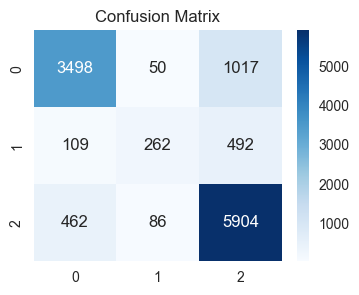

In [27]:
y_rfgs_train = rf_gs.predict(X_train)
y_rfgs_test = rf_gs.predict(X_test)
y_rfgs_cv = rf_gs.best_score_
print(rf_gs.best_estimator_)
print('Cross-validated Accuracy: '); print("="*len("Cross-validated Accuracy:")); print(y_rfgs_cv)
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_rfgs_train)}")
print(f"TEST: {accuracy_score(y_test, y_rfgs_test)}")
cm = confusion_matrix(y_test, y_rfgs_test)
plt.figure(figsize=(4, 3))
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True,cmap='Blues',fmt='d')

ExtraTreesClassifier(max_depth=20, n_estimators=300)
Cross-validated Accuracy:
0.8000420875420875
Accuracy:
TRAIN: 0.9371212121212121
TEST: 0.8072390572390572


<Axes: title={'center': 'Confusion Matrix'}>

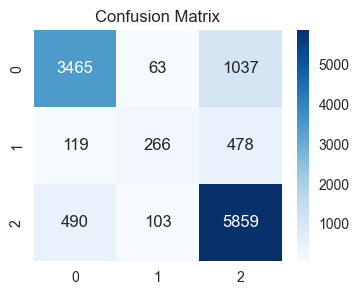

In [28]:
print(et_gs.best_estimator_)
y_et_gs_train = et_gs.predict(X_train)
y_et_gs_test = et_gs.predict(X_test)
y_et_gs_cv = et_gs.best_score_
print('Cross-validated Accuracy:')
print("=" * len("Cross-validated Accuracy:"))
print(y_et_gs_cv)
print("Accuracy:")
print("=" * len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_et_gs_train)}")
print(f"TEST: {accuracy_score(y_test, y_et_gs_test)}")
cm = confusion_matrix(y_test, y_et_gs_test)
plt.figure(figsize=(4, 3))
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

Cross-validated Accuracy:
0.8017676767676768
Accuracy:
TRAIN: 0.9023779461279461
TEST: 0.8072390572390572


<Axes: title={'center': 'Confusion Matrix'}>

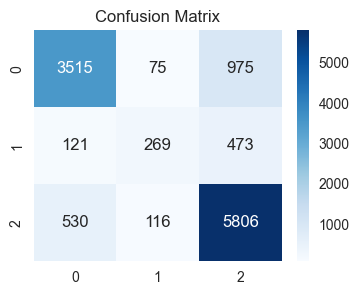

In [29]:
y_lgbm_gs_train = lgbm_gs.predict(X_train)
y_lgbm_gs_test = lgbm_gs.predict(X_test)
y_lgbm_gs_cv = lgbm_gs.best_score_
print('Cross-validated Accuracy:')
print("=" * len("Cross-validated Accuracy:"))
print(y_lgbm_gs_cv)
print("Accuracy:")
print("=" * len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_lgbm_gs_train)}")
print(f"TEST: {accuracy_score(y_test, y_lgbm_gs_test)}")
cm = confusion_matrix(y_test, y_lgbm_gs_test)
plt.figure(figsize=(4, 3))
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

### 5.9 Votting Classifier

<class 'sklearn.ensemble._voting.VotingClassifier'>
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1241
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 19
[LightGBM] [Info] Start training from score -0.956493
[LightGBM] [Info] Start training from score -2.621618
[LightGBM] [Info] Start training from score -0.610505
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1239
[LightGBM] [Info] Number of data points in the train set: 47520, number of used features: 19
[LightGBM] [Info] Start training from score -0.956493
[LightGBM] [Info] St

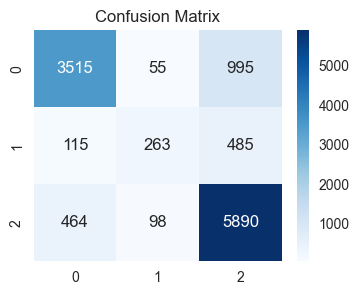

In [30]:
voting_classifier = VotingClassifier(
    estimators=[('rf',rf_gs.best_estimator_), ('gb', best_lgbm), ('et', best_et)],
    voting='soft' 
)
print(voting_classifier.__class__)
voting_classifier.fit(X_train, y_train)
y_voting_train = voting_classifier.predict(X_train)
y_voting_test = voting_classifier.predict(X_test)
y_voting_cv = cross_val_score(voting_classifier, X, y, cv=5, scoring='accuracy')
print('Cross-validated Accuracy:')
print("=" * len("Cross-validated Accuracy:"))
print(y_voting_cv.mean())
print("Accuracy:")
print("=" * len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_voting_train)}")
print(f"TEST: {accuracy_score(y_test, y_voting_test)}")
cm = confusion_matrix(y_test, y_voting_test)
plt.figure(figsize=(4, 3))
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.show()

In [31]:
comparison_cv = pd.DataFrame({
    'Model':[
        'Random Forest GS',
        'Extra Trees GS',
        'Light Booster Machine GS',
        'Votting Classifier',
    ], 
    'Cross-validated accuracy':[
        y_rfgs_cv,
        y_et_gs_cv,
        y_lgbm_gs_cv,
        y_voting_cv.mean()

    ]
})

print('--- Comparison cross-validated accuracy---')
print('='*len('--- Comparison cross-validated accuracy---'))
comparison_cv.sort_values('Cross-validated accuracy', ascending = False)

--- Comparison cross-validated accuracy---


,Model,Cross-validated accuracy
3,Votting Classifier,0.810051
0,Random Forest GS,0.805093
2,Light Booster Machine GS,0.801768
1,Extra Trees GS,0.800042


Tras realizar el entrenamiento y test para cada uno de los modelos nos encontramos con mejoras significantes en todos ellos. Ademas una mejora de 0.05 puntos porcentuales utilizando el _Votting Classifier_. Por lo tanto, ya tenemos candidato para nuestro concurso.

#### 6. Prediccion

In [33]:
y_vc = voting_classifier.predict(test)
vc = pd.DataFrame(y_vc, 
                    columns=['status_group'], index = id)
vc['status_group'] = vc['status_group'].map(  {0:'non functional',
                                                1:'functional needs repair',
                                                2:'functional'} )
vc.to_csv('VotingClassifier.csv')

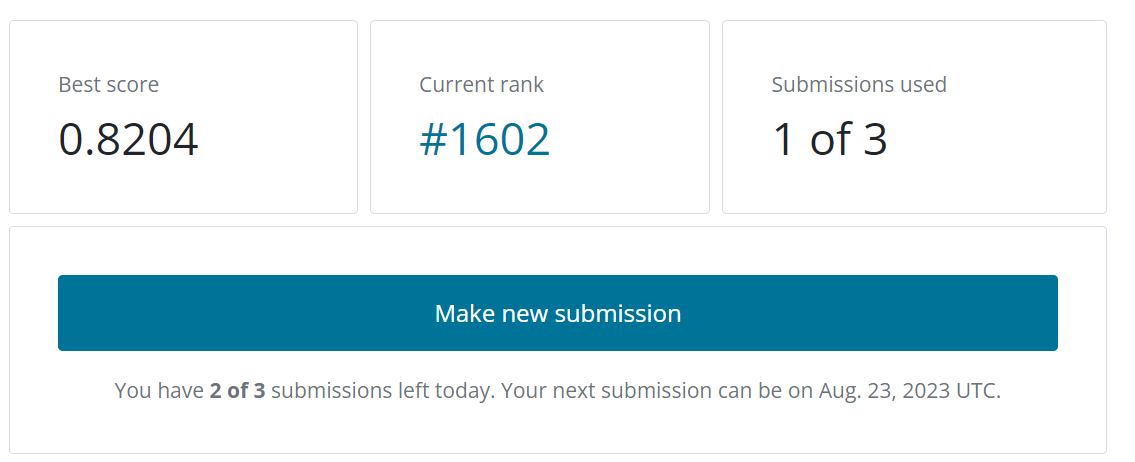